In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models
from PipelineStages import Loader, ImageProcessing, Labeler, DatasetBuilder, ModelTrainer

2023-07-06 11:58:17.197309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms"
model = models.load_model(path + "/model1.h5")

In [28]:
loader = Loader.Loader(20, 100, path)
stack, tot_loops, info = loader.run()

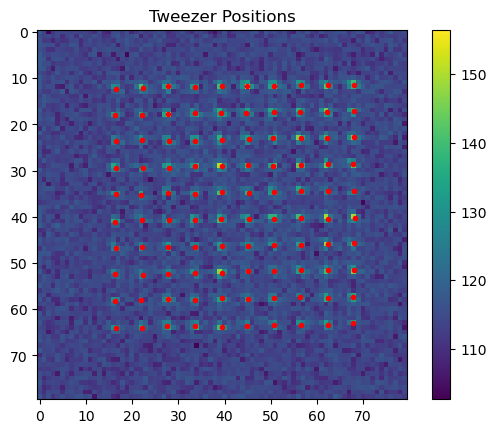

In [29]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

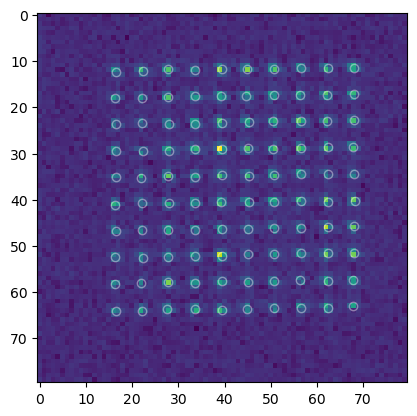

In [30]:
plt.imshow(np.mean(processor.fractional_stack(8), axis=0).T)
plt.plot(*positions.T, 'wo', fillstyle='none', alpha=0.4)

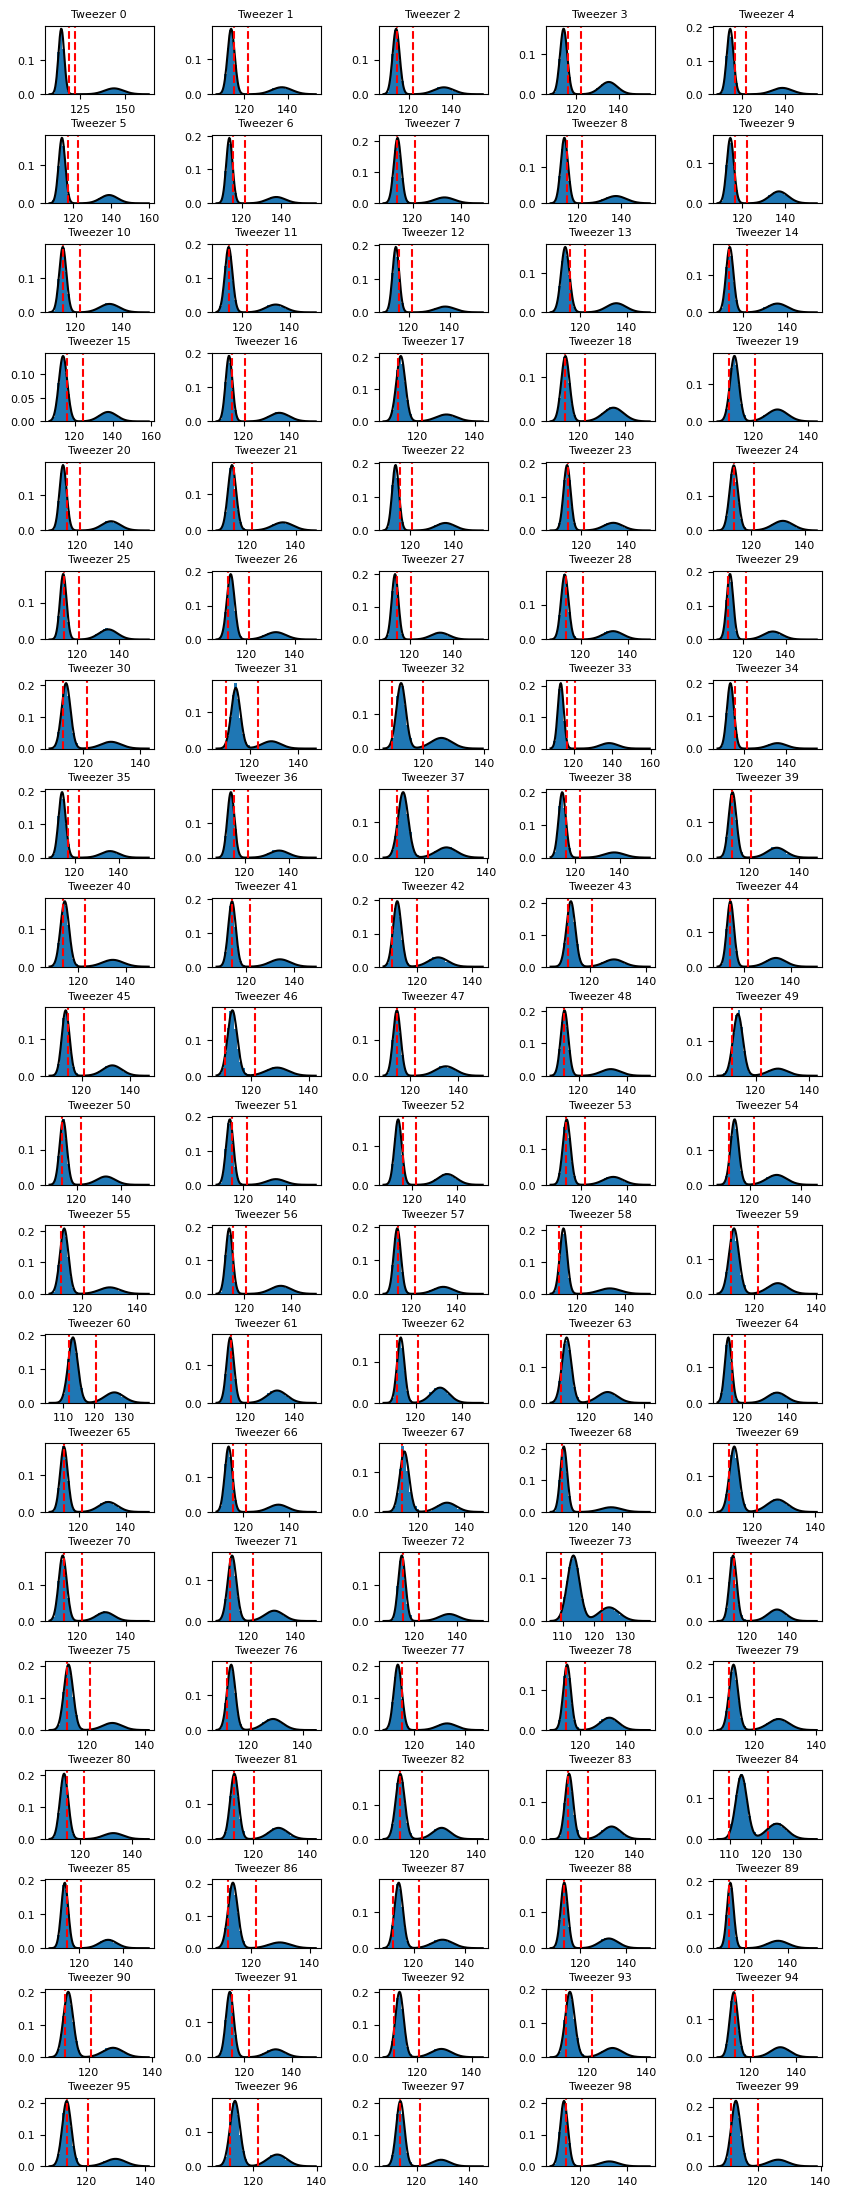

In [31]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

In [32]:
builder = DatasetBuilder.DatasetBuilder(crops3x3, labels)
training, testing, fidelity, info = builder.run()

In [33]:
print(info["Training Bright Fraction"])
print(info["Labeled Dataset Fraction"])

0.24918339640509457
0.962702564102564


In [19]:
trainer = ModelTrainer.ModelTrainer(model, training, testing, fidelity, 100, tot_loops, epochs=1)
model, info = trainer.run()

ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 16, 16, 1), found shape=(None, 17, 17)


UnicodeDecodeError: 'ascii' codec can't decode byte 0x89 in position 0: ordinal not in range(128)

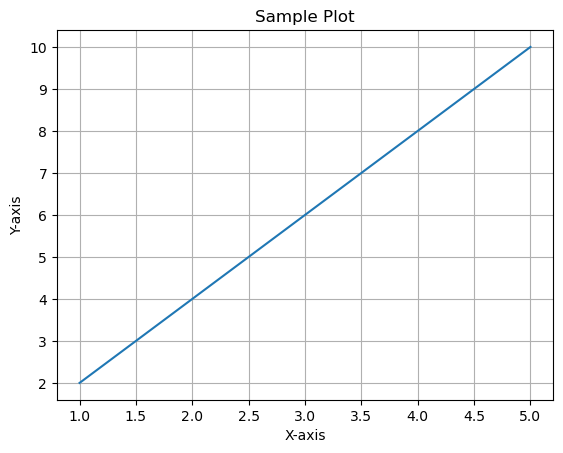

In [36]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import matplotlib.pyplot as plt

def create_pdf_from_dictionary(data_dict, filename):
    # Create a new PDF document
    c = canvas.Canvas(filename, pagesize=letter)

    # Set the font
    c.setFont("Helvetica", 12)

    # Loop through the dictionary and add the strings and plots to the PDF
    for key, value in data_dict.items():
        if isinstance(value, str):
            # Add string to the PDF
            c.drawString(50, c._pagesize[1] - 50, f"{key}: {value}")
        elif isinstance(value, plt.Figure):
            # Save the plot to a temporary image file
            temp_image_file = "temp_plot.png"
            value.savefig(temp_image_file)

            # Add the plot to the PDF
            c.drawImage(temp_image_file, 50, c._pagesize[1] - 200, width=400, height=300)

            # Remove the temporary image file
            plt.close(value)
            import os
            os.remove(temp_image_file)

        # Move to the next page if necessary
        if c._pagesize[1] - c._y < 200:
            c.showPage()

    # Save the PDF document
    c.save()

# Example usage
data = {
    "Title": "Example PDF",
    "Description": "This is an example PDF document.",
    "Plot": plt.figure()
}

create_pdf_from_dictionary(data, "example.pdf")
